# Introduction

L'objectif de ce notebook est d'aborder le calcul d'un score d'un réseau bayésien, générer une séquence de réseaux et comparer leur scores, et enfin déterminer les probabilités conditionnelles inhérente à un réseau. Nous comparerons également l'approche des probabilités conditionnelles via les réseaux bayésiens et la classification naïve bayésienne.

# Manipulation des réseaux bayésiens

On utilise les deux fichiers `titanic.gph` & `wine.gph` pour générer des réseaux bayésiens sous la forme de graphe. Nous utiliseront `networkx` pour effectuer cette modélisation, sous la forme d'un graphe orienté.

In [21]:
import networkx as nx

def graph_from_gph(path:str)->nx.DiGraph:
    edges = [tuple(l.strip('\n').split(', ')) for l in open(path).readlines()]
    graph = nx.DiGraph()
    graph.add_edges_from(edges)
    return graph

titanic_graph:nx.DiGraph = graph_from_gph('../titanic.gph')
wine_graph:nx.DiGraph = graph_from_gph('../wine.gph')

Soit pour nos deux datasets :

In [23]:
import pandas as pd

titanic_df:pd.DataFrame = pd.read_csv('datasets/small.csv')
wine_df:pd.DataFrame = pd.read_csv('datasets/medium.csv')

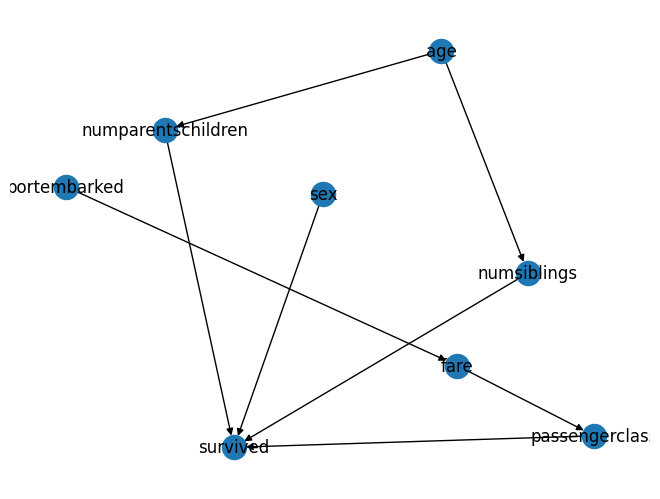

In [24]:
# Graphe Titanic

from matplotlib import pyplot as plt
nx.draw(titanic_graph, with_labels=True)
plt.show()

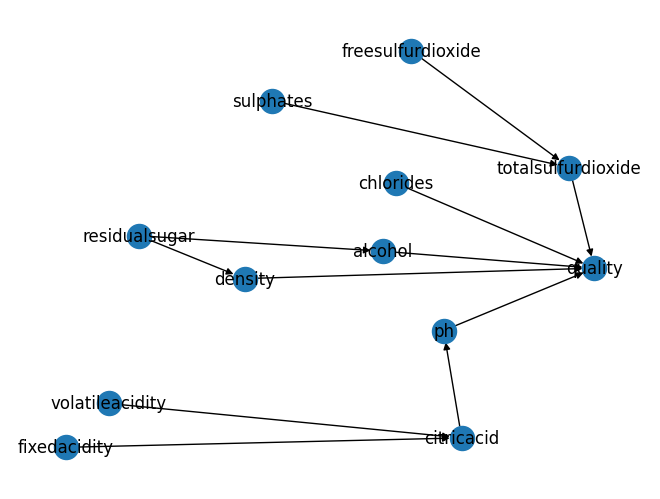

In [25]:
# Graphe Wine

from matplotlib import pyplot as plt
nx.draw(wine_graph, with_labels=True)
plt.show()

# Estimation du nombre de DAG possible pour chaque dataset

Nous avons codé une fonction permettant d'estimer le nombre de DAG (Directed Acyclic Graph) pour un ordre n donné. Cela permet d'obtenir le nombre de possibilité pour nos deux datasets.

In [22]:
from math import comb

def maxDAG(n:int)->int:
    if n == 0 :
        return 1
    else :
        res = 0
        for i in range(1, n + 1):
            res+=((-1)**(i-1))*comb(n, i)*(2**(i*(n-i)))*maxDAG(n-i)
        return res

Pour nos deux datasets, on obtient donc :

In [66]:
{
    "titanic": maxDAG(titanic_df.columns.__len__()),
    "wine": maxDAG(wine_df.columns.__len__())
}

{'titanic': 783702329343, 'wine': 521939651343829405020504063}

# Calculer le score d'un réseau

Nous utiliserons comme inspiration la fonction mathématique score(G|D) pour écrire une méthode permettant de calculer le score d'un réseau bayésien en fonction du dataset qui lui est associé.

Pour cela, nous écrivons une classe présentant des méthodes, permettant de calculer les éléments suivants :

- $r_{i}$ : Le nombre de valeurs que la variable $x_i$ peut prendre
  - Pour cela, on retourne la longueur d'un set de la colonne $x_i$
- $q_i$ : Le produit du nombre d'instanciations possibles que chaque parent direct de $x_i$ peut prendre
  - Pour cela, on multiplie les valeurs $r_i$ de chaque parent
- $\pi_{ij}$ : La $j$ème instanciation des parents de $x_i$, représentés sous la forme d'un tuple
  - Pour cela, on génère l'ensemble des instanciations simultanées possibles sous la forme d'une liste de tuples puis, si $j$ est précisé, on renvoie le tuple à l'indice $j$
- $m_{ijk}$ : Le nombre de fois où, dans le dataset, $X_i$ est égal à $k$ et ses parents correspondent à l'instanciation $\pi_{ij}$
  - Pour cela, on itère dans une liste des parents de $x_i$ et dans la liste des instanciations donnée par $\pi_{ij}$, et on incrémente une variable à chaque fois que la condition est vérifiée
- $score(G|D)$ : La fonction de score nécessaire à l'évaluation d'un graphe
  - Cette fonction résulte de l'implémentation directe de la fonction de l'énoncé.

In [26]:
import itertools as itrt
from mpmath import log, factorial

class Scoring:

    def __init__(self, G:nx.DiGraph, D:pd.DataFrame):
        self.G = G
        self.D = D
    

    def r(self, x_i:str)->int:
        return len(set(self.D[x_i]))


    def get_parents(self, node:str)->list:
        return list(self.G.predecessors(node))
    

    def q(self, x_i:str)->int:
        result = 1

        for i in self.get_parents(x_i):
            result *= self.r(i)
        
        return result


    def get_possible_instances(self, x_i:str)->tuple:
        return tuple(set(self.D[x_i]))


    def pi(self, x_i:str, j:int=None)->list|tuple:

        parents_instances = [self.get_possible_instances(parent) for parent in self.get_parents(x_i)]

        pairs = list(itrt.product(*parents_instances))

        if j:
            assert j < len(pairs)
        
        return pairs[j] if j else pairs


    def m(self, x_i:str, j:int, k: int)->int:

        result = 0
        parents = self.get_parents(x_i)

        if k == 0:

            for new_k in range(self.r(x_i)):
                result += self.m(x_i, j, new_k+1)
            
            return result
                
        if len(parents) != 0:
            
            instances = self.pi(x_i)
        
            for i, value in enumerate(self.D[x_i]):
        
                count = 0

                for l, value in enumerate(instances[j-1]):
                    
                    if self.D[x_i][i] == k and self.D[parents[l]][i] == instances[j-1][l]:
                        count+=1
                        
                    
                if(count==len(instances[j-1])):
                    result+=1

            return result
        
        else:

            for i, value in enumerate(self.D[x_i]):
                if self.D[x_i][i] == k:
                    result+=1
                
            return result    


    def score(self)->float:
        result = 0

        for i in self.D.columns:
            temp_sum = 0

            for j in range(1,self.q(i)+1):

                temp_sum += (
                    log(factorial(self.r(i)-1)) 
                    - log(
                        factorial(self.r(i) + self.m(i,j,0) - 1)
                    ) 
                    + sum([
                        log(
                           factorial((1+self.m(i,j,z))-1)
                        ) for z in range(1,self.r(i)+1)
                    ])
                )

            result += temp_sum
            
        return float(result)

Nous pouvons désormais calculer le score de nos deux graphes :

In [27]:
# Le calcul du score du dataset Wine est très long (de plusieurs dizaines de minutes à plus d'une heure). Si vous souhaitez lancer le calcul, changez la variable ci-dessous en True. Sinon, la valeur affichée sera celle que nous avons précédemment calculé.
calculate_wine_score:bool = False

scoring_titanic = Scoring(titanic_graph, titanic_df)
scoring_wine = Scoring(wine_graph, wine_df)

{
    "titanic": scoring_titanic.score(),
    "wine": scoring_wine.score() if calculate_wine_score else -43344.921630608056
}

{'titanic': -3952.558735240772, 'wine': -43344.921630608056}

# Générer une séquence de réseaux

Ici, l'objectif est de générer des graphes aléatoires afin de maximiser le score, et ainsi d'obtenir le meilleur réseau bayésien possible pour le dataset fourni. Pour cela, nous écrivons une fonction générant $n$ graphes aléatoires, et sélectionons le meilleur selon son score.

In [28]:
# Le code ci-dessous est le fruit exclusif de notre travail, à l'unique exception de l'optimisation via ThreadPoolExecutor, proposée par ChatGPT

import random as rd
from typing import List
import concurrent.futures

def create_random_graph(data:pd.DataFrame, n:int)->List[nx.DiGraph]:
    listGraphes = []

    for i in range(n):
        graph = nx.DiGraph()
        for at in data.columns:
            graph.add_node(at)
        while nx.is_directed_acyclic_graph(graph):
            randomEdge = (rd.choice(data.columns.to_list()), rd.choice(data.columns.to_list()))
            # print(randomEdge)
            if randomEdge[0] != randomEdge[1]:
                graph.add_edge(randomEdge[0], randomEdge[1])
        listGraphes.append(graph)
    # nx.draw_networkx(graph, arrows=True)
    # plt.show()
    return listGraphes

def best_graph(data: pd.DataFrame, n: int) -> list:
    res = []
    graphes = create_random_graph(data, n)

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []

        for g in graphes:
            future = executor.submit(scoring_worker, g, data)
            futures.append(future)

        for future in concurrent.futures.as_completed(futures):
            res.append(future.result())

    return sorted(res, key=lambda x: x['score'], reverse=True)


def scoring_worker(graph, data):
    scoring = Scoring(graph, data)
    g_res = {}
    g_res["score"] = scoring.score()
    g_res["graph"] = list(graph.edges())
    return g_res

Voici un exemple de trois graphes générés par `best_graph` pour le dataset Titanic, ainsi que leur scores triés par ordre décroissant.

In [29]:
best_graph(titanic_df, 3)

[{'score': -3943.859210727245,
  'graph': [('age', 'numparentschildren'),
   ('portembarked', 'sex'),
   ('portembarked', 'numparentschildren'),
   ('fare', 'numsiblings'),
   ('numparentschildren', 'portembarked'),
   ('passengerclass', 'age'),
   ('passengerclass', 'survived'),
   ('sex', 'survived'),
   ('numsiblings', 'numparentschildren'),
   ('numsiblings', 'sex'),
   ('numsiblings', 'survived')]},
 {'score': -4059.526921791172,
  'graph': [('age', 'portembarked'),
   ('portembarked', 'fare'),
   ('portembarked', 'age'),
   ('portembarked', 'numsiblings'),
   ('numparentschildren', 'numsiblings'),
   ('passengerclass', 'fare'),
   ('sex', 'survived'),
   ('sex', 'passengerclass'),
   ('sex', 'fare'),
   ('sex', 'age'),
   ('numsiblings', 'passengerclass'),
   ('survived', 'passengerclass'),
   ('survived', 'fare'),
   ('survived', 'numparentschildren')]},
 {'score': -4194.601234762808,
  'graph': [('age', 'fare'),
   ('portembarked', 'survived'),
   ('portembarked', 'fare'),
   (

Et un exemple de trois graphes pour le dataset Wine. Il est à noter que, à l'instar de la démonstration de la méthode `score()`, la génération des graphes pour le dataset Wine prennent un temps considérable (plusieurs minutes).

In [30]:
# La variable ci-dessous est à False par défaut. Dans ce cas, les graphes affichés proviennent d'une exécution antérieure et sont stockés dans une variable. Pour lancer la génération (qui peut prendre plusieurs minutes), vous pouvez changer la valeur de cette variable à True.
generate_wine_graphs:bool = False

best_graph(wine_df, 3) if generate_wine_graphs else [
    {
        'score': -44208.999426677736,
        'graph': [('volatileacidity', 'quality'),
        ('volatileacidity', 'totalsulfurdioxide'),
        ('citricacid', 'quality'),
        ('residualsugar', 'volatileacidity'),
        ('residualsugar', 'density'),
        ('freesulfurdioxide', 'totalsulfurdioxide'),
        ('totalsulfurdioxide', 'freesulfurdioxide'),
        ('ph', 'residualsugar'),
        ('ph', 'freesulfurdioxide'),
        ('ph', 'citricacid')]
    },
    {
        'score': -45512.75124596456,
        'graph': [('fixedacidity', 'volatileacidity'),
        ('residualsugar', 'quality'),
        ('residualsugar', 'freesulfurdioxide'),
        ('chlorides', 'sulphates'),
        ('chlorides', 'quality'),
        ('density', 'fixedacidity'),
        ('density', 'citricacid'),
        ('ph', 'freesulfurdioxide'),
        ('ph', 'quality'),
        ('sulphates', 'freesulfurdioxide'),
        ('alcohol', 'chlorides'),
        ('alcohol', 'ph'),
        ('quality', 'ph')]
   },
   {
        'score': -45838.35246489307,
        'graph': [('volatileacidity', 'chlorides'),
        ('chlorides', 'alcohol'),
        ('ph', 'volatileacidity'),
        ('ph', 'citricacid'),
        ('sulphates', 'volatileacidity'),
        ('sulphates', 'chlorides'),
        ('alcohol', 'freesulfurdioxide'),
        ('alcohol', 'chlorides')]
   }
]

[{'score': -44208.999426677736,
  'graph': [('volatileacidity', 'quality'),
   ('volatileacidity', 'totalsulfurdioxide'),
   ('citricacid', 'quality'),
   ('residualsugar', 'volatileacidity'),
   ('residualsugar', 'density'),
   ('freesulfurdioxide', 'totalsulfurdioxide'),
   ('totalsulfurdioxide', 'freesulfurdioxide'),
   ('ph', 'residualsugar'),
   ('ph', 'freesulfurdioxide'),
   ('ph', 'citricacid')]},
 {'score': -45512.75124596456,
  'graph': [('fixedacidity', 'volatileacidity'),
   ('residualsugar', 'quality'),
   ('residualsugar', 'freesulfurdioxide'),
   ('chlorides', 'sulphates'),
   ('chlorides', 'quality'),
   ('density', 'fixedacidity'),
   ('density', 'citricacid'),
   ('ph', 'freesulfurdioxide'),
   ('ph', 'quality'),
   ('sulphates', 'freesulfurdioxide'),
   ('alcohol', 'chlorides'),
   ('alcohol', 'ph'),
   ('quality', 'ph')]},
 {'score': -45838.35246489307,
  'graph': [('volatileacidity', 'chlorides'),
   ('chlorides', 'alcohol'),
   ('ph', 'volatileacidity'),
   ('ph',

## Limites

Nous avons observé des limites à la génération de graphes aléatoires avec un score leur étant associé. La limite primordiale étant que le graphe généré ne respecte ni les conditions logiques relatives aux noeuds (on peut obtenir des graphes avec des connexions insensées), ni la répartition des valeurs dans le dataset pouvant justifier les connexions générées.

Il s'agit d'aléatoire, dont l'objectif est de filtrer les graphes les plus cohérents via une analyse humaine, avant de les filtrer par leur score.

# Déterminer les probabilités conditionnelles

Notre objectif va être ici d'écrire les tables de probabilité de nos réseaux bayésiens, grâce à une fonction $P(donnée|conditions)$.

En somme, obtenir une probabilité conditionnelle grâce à une requête de type $P(donnée=4 | donnée_a=1, donnée_b=2, donnée_c=3, ...)$

Pour cela, on code la fonction `p`. Cette fonction va, pour chaque condition, restreindre le dataset, puis finalement retourner la proportion où la donnée est égale à la valeur indiquée, dans ce dataset réduit.

In [64]:
from typing import Dict

def p(dataframe:pd.DataFrame, x:str, valeurX:int, **conditions:Dict[str, int])->float:
    df_copy:pd.DataFrame = dataframe

    for key, value in conditions.items():
        df_copy = df_copy.loc[df_copy[key] == value]

    result = len([i for i in df_copy[x] if i == valeurX])/df_copy.__len__()

    return round(result, 3)

Voici quelques exemples :

In [65]:
# Dataset Titanic
{
    "P(survived=1 | passengerclass=1, numparentschildren=1, numsiblings=1, sex=1)": p(titanic_df, "survived", 1, passengerclass=1, numparentschildren=1, numsiblings=1, sex=1),
    "P(passengerclass=3 | fare=1)": p(titanic_df, "passengerclass", 3, fare=1),
    "P(survived=2 | numparentschildren=2, numsiblings=3)": p(titanic_df, "survived", 2, numparentschildren=2, numsiblings=1)
}

{'P(survived=1 | passengerclass=1, numparentschildren=1, numsiblings=1, sex=1)': 0.86,
 'P(passengerclass=3 | fare=1)': 0.212,
 'P(survived=2 | numparentschildren=2, numsiblings=3)': 0.667}

In [69]:
# Dataset Wine
{
    "P(quality=4 | alcohol=3, density=1, ph=2, totalsulfurdioxide=1)": p(wine_df, "quality", 4, alcohol=3, density=1, ph=2, totalsulfurdioxide=1),
    "P(totalsulfurdioxide=2 | sulphates=5, freesulfurdioxide=1)": p(wine_df, "totalsulfurdioxide", 2, sulphates=5, freesulfurdioxide=1),
    "P(quality=1 | ph=1, alcohol=2)": p(wine_df, "quality", 1, ph=1, alcohol=2)
}

{'P(quality=4 | alcohol=3, density=1, ph=2, totalsulfurdioxide=1)': 0.167,
 'P(totalsulfurdioxide=2 | sulphates=5, freesulfurdioxide=1)': 0.818,
 'P(quality=1 | ph=1, alcohol=2)': 0.135}

Ainsi, itérer grâce à cette fonction permet d'obtenir l'ensemble des probabilités conditionnelles des graphes. Cependant, considérant la taille de ces derniers, nous n'avons pas jugé utile de modéliser ces dites tables en applicant, de façon exhaustive, cette fonction.